> # Neural Network Basic - Week3 과제


## Import Library

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [2]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [3]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [22]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1/(1 + np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x): 
        a = 1/(1 + np.exp(-x))
        return a*(1-a)

In [5]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return x if x>0 else 0
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return 1 if x>0 else 0

In [6]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [7]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [8]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [18]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr #학습률
        self.epoch = epoch  # 전체 데이터 셋에 대해 학습 정도
        self.batch_size = batch_size # 한 번의 batch마다 주는 데이터 샘플의 size
        self.loss_function = cross_entropy # 오차함수 cross_entropy 사용
        self.layers = [] #쌓을 층
        self.activations = [softmax] #활성화함수
        self.nodes = [] #각 층의 노드 
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) 
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size)) # self.nodes가 비어있으면, Layer 인풋사이즈만큼 넣어주기
        self.nodes.append(np.zeros(Layer.output_size))  # self.nodes가 비어 있지 않으면, Layer 인풋사이즈만큼 넣어주기
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() # self.activations의 마지막 요소 tmp 변수로 지정
        self.activations.append(Activation) # self.activations에 Activation 넣어주기
        self.activations.append(tmp)  # self.activations에 tmp 넣어주기
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() 
        output = X.copy() 
        for i in range(len(self.layers)): 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            output = np.dot(self.nodes[i], Layer.weight) # i번째 self.nodes와 Layer.weight 행렬곱해주기
            output = output+ Layer.bias # bias 더해주기
            output = Activation.forward(output) # forward 함수 사용해 결과 도출해주기
            self.nodes[i+1] = output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): 
            a = self.nodes[i+1] 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            
            if i+1 == len(self.layers): 
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] # 반복하면서 weight값 빼주기
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0] # 반복하면서 bias값 빼주기
            error = np.dot(error, Layer.weight.T) # error, Layer.weight값 행렬곱해서 error 출력하기
            
    # Accuracy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) # 결과값 중 최대값 출력하기
        return np.sum(pre_p==y)/y.shape[0] 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):
            for j in range(N//self.batch_size): 
                batch_mask = np.random.choice(N, self.batch_size) # batch_size 랜덤으로 고르기
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) # forward 함수 사용해 output 출력
                self._backward(X_batch, output, y_batch) # backward 함수 사용해 output 출력
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [23]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [24]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [25]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23345.692273570316
10 test accuracy : 0.1969
10 test loss     : 22806.184902351793
20 test accuracy : 0.2323
20 test loss     : 22560.745884393677
30 test accuracy : 0.2252
30 test loss     : 22148.58108035562
40 test accuracy : 0.2259
40 test loss     : 21360.847059976517
50 test accuracy : 0.2423
50 test loss     : 20146.17814488818
60 test accuracy : 0.3038
60 test loss     : 18912.842322018736
70 test accuracy : 0.4347
70 test loss     : 17617.463140667962
80 test accuracy : 0.5093
80 test loss     : 15902.64658336706
90 test accuracy : 0.5659
90 test loss     : 14016.770247505581
100 test accuracy : 0.6139
100 test loss     : 12264.656865147695
110 test accuracy : 0.6626
110 test loss     : 10789.260495895822
120 test accuracy : 0.7115
120 test loss     : 9627.710334202297
130 test accuracy : 0.7449
130 test loss     : 8696.396607960896
140 test accuracy : 0.7752
140 test loss     : 7906.7902821192965
150 test accuracy : 0.8037
150 test l

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

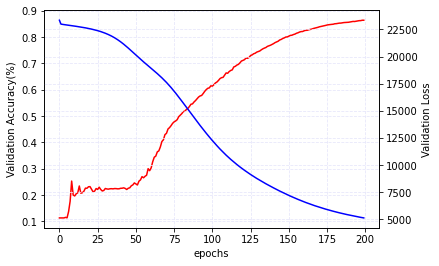

In [33]:
fig = plt.figure()
ax_acc = fig.add_subplot()

ax_acc.plot(range(200), history['val_acc'], label='정확도', color='red')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')

ax_loss = ax_acc.twinx()
ax_loss.plot(range(200), history['val_loss'], label='오차', color='blue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()